Find Metrics most correlated to SBS

In [1]:
#Import Modules
import sys
sys.path.append("..") #give this script access to all modules in parent directory
from pathlib import Path
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import tsfel
from operator import itemgetter
import os
from Data_Cleaning import preprocess
import Actigraph_Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statistics



c:\Users\sidha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\sidha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:59: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# signal parameters
freq = 100 #signal is 100hz

Load All Patient Data

In [3]:
#Change to Load data of interest
data_dir = 'C:/Users/sidha/OneDrive/Sid Stuff/PROJECTS/iMEDS Design Team/Data Analysis/PedAccel/data_analysis/PythonPipeline/PatientData'

# data_dir = r'C:\Users\jakes\Documents\DT 6 Analysis\PythonCode\PedAccel\data_analysis\PythonPipeline\PatientData'


#set params
slice_size_min = 15
lead_time = 10
window_size = 100 #100 is 1 second worth of time

In [4]:


#Change for data of interest
#preprocess.load_and_segment_data(data_dir, slice_size_min, lead_time) #take sbs csv and accel gt3x to create a .mat file with vector magnitudes

Generate Most correlated features for some signal 

1
The top N value pairs are {'0_FFT mean coefficient_187': 0.658401408433941, '0_FFT mean coefficient_171': 0.6257379699481092, '0_FFT mean coefficient_22': 0.6089003760214055}


c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


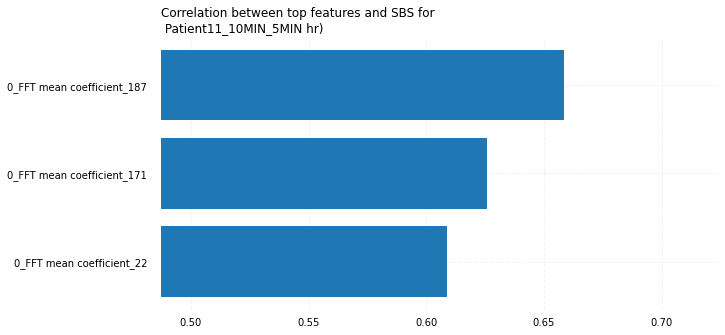

1
The top N value pairs are {'0_FFT mean coefficient_187': 0.42994746366368164, '0_FFT mean coefficient_22': 0.40418403668048897, '0_FFT mean coefficient_121': 0.40212083645459307}


c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


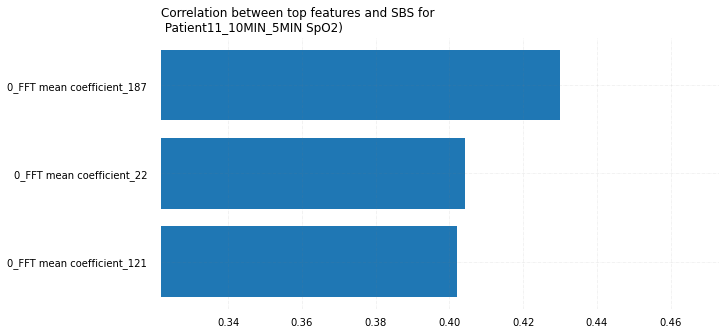

IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
#There is no error handling in place, the .mat file must exist
for patient in os.listdir(data_dir):
        # filter out non-directories
        patient_dir = os.path.join(data_dir, patient)
        if os.path.isdir(patient_dir):
            data_filepath_accel = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN.mat')           
            data_filepath_vitals = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN.mat')

 
        accel_data = loadmat(data_filepath_accel)
        x_mag = accel_data["x_mag"]
        accel_SBS = accel_data["sbs"]
        
        vitals_data = loadmat(data_filepath_vitals)
        hr = vitals_data['heart_rate']
        SpO2 = vitals_data['SpO2']
        rr = vitals_data['respiratory_rate']
        bps = vitals_data['blood_pressure_systolic']
        bpm = vitals_data['blood_pressure_mean']
        bpd = vitals_data['blood_pressure_diastolic']
        vitals_SBS = vitals_data['sbs']


        fs = .5

        # Generate configuration file for feature extraction
        cfg_file = tsfel.get_features_by_domain()

        # Extract features and restructure data
        features_list = []
        sbs_list = []
        signal_list = [hr, SpO2, rr, bps, bpm, bpd]
        signal_names = ['hr', 'SpO2', 'rr', 'bps', 'bpm', 'bpd', 'vitals_SBS']
        count = 0
        for signal in signal_list: 
            #Can change the signal            
            for i in range(len(signal.squeeze())):
                #signal = Actigraph_Metrics.VecMag_MAD(x_mag[i,:],100)
                sbs_list.append(vitals_SBS.squeeze()[i])
                features = tsfel.time_series_features_extractor(cfg_file, signal[i], fs, verbose=0)
                features_list.append(features)
            print(len(features_list[0]))

            #list comprehension for column names
            columns = [col for col in list(features_list[0])]
            # Convert features and SBS scores to DataFrame
            features_array = np.array(features_list).reshape(-1, len(columns)) #may need to change 389
            df_features = pd.DataFrame(features_array)

            df_features.columns = columns

            #Pearson Correlation Coefficient
            CCoeff = []
            for i in columns:
                y = sbs_list
                myX = list(df_features[i])
                nan_indices = [i for i, x in enumerate(myX) if math.isnan(x)]
                myX = [x for x in myX if not math.isnan(x)]
                cleaned_y = [val for idx, val in enumerate(y) if idx not in nan_indices]

                corr, _ = pearsonr(cleaned_y, myX)
                CCoeff.append(np.abs(corr))
            my_dict = dict(zip(list(columns), list(CCoeff)))

            # functional
            clean_dict = filter(lambda k: not math.isnan(my_dict[k]), my_dict)
            # dict comprehension
            clean_dict = {k: my_dict[k] for k in my_dict if not math.isnan(my_dict[k])}

            #Retrieve N features with best correlation coefficient  
            # Initialize N
            N = 3
            
            # N largest values in dictionary
            # Using sorted() + itemgetter() + items()
            res = dict(sorted(clean_dict.items(), key=itemgetter(1), reverse=True)[:N])

            # printing result
            print("The top N value pairs are " + str(res))

            #Plot a histogram
            y = list(res.keys())
            x = list(res.values()) #price
            
            if len(x) != 0:
                # Figure Size
                fig, ax = plt.subplots(figsize =(10 ,5))
                
                # Horizontal Bar Plot
                ax.barh(y, x)
                
                # Remove axes splines
                for s in ['top', 'bottom', 'left', 'right']:
                    ax.spines[s].set_visible(False)
                
                # Remove x, y Ticks
                ax.xaxis.set_ticks_position('none')
                ax.yaxis.set_ticks_position('none')
                
                # Add padding between axes and labels
                ax.xaxis.set_tick_params(pad = 5)
                ax.yaxis.set_tick_params(pad = 10)
                
                # Add x, y gridlines
                ax.grid(color ='grey',
                        linestyle ='-.', linewidth = 0.5,
                        alpha = 0.2)
                
                # Show top values 
                ax.invert_yaxis()

                #set x axis range
                ax.set_xlim([.8*min(x),1.1*max(x)])
            
                # Add Plot Title
                ax.set_title(f'Correlation between top features and SBS for\n {patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN {signal_names[count]})',
                            loc ='left', )
                
                # Show Plot

                plt.show()
                count= count+1